참고 : 
* https://www.kaggle.com/linxinzhe/tensorflow-deep-learning-to-solve-titanic
* https://github.com/linxinzhe/tensorflow-titanic/blob/master/tensorflow_titanic.ipynb

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load Data

In [2]:
# 판다스를 통해 데이터를 로드해 온다.
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [3]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
# 티켓은 정제가 되어 있지 않아서 정제해야만 사용할 수 있다.
train_data['Ticket'].value_counts().head(10)

CA. 2343        7
347082          7
1601            7
3101295         6
347088          6
CA 2144         6
S.O.C. 14879    5
382652          5
347077          4
PC 17757        4
Name: Ticket, dtype: int64

In [9]:
# 선실 정보 또한 정제가 되어 있지 않아서 정제해야만 사용할 수 있다.
train_data['Cabin'].value_counts().head(5)

G6             4
B96 B98        4
C23 C25 C27    4
F33            3
C22 C26        3
Name: Cabin, dtype: int64

## Feature Engineering

In [10]:
from sklearn.preprocessing import Imputer

# 결측치를 보완해 준다.
def nan_padding(data, columns):
    for column in columns:
        imputer = Imputer()
        data[column] = imputer.fit_transform(data[column].values.reshape(-1,1))
    return data


nan_columns = ["Age", "SibSp", "Parch", "Fare"]

train_data = nan_padding(train_data, nan_columns)
test_data = nan_padding(test_data, nan_columns)

In [11]:
# save PassengerId for evaluation
# 평가를 위해 승객Id를 따로 저장해 둔다.
test_passenger_id = test_data["PassengerId"]

In [12]:
# 사용하지 않을 컬럼을 제거해 준다.
def drop_not_concerned(data, columns):
    return data.drop(columns, axis=1)

not_concerned_columns = ["PassengerId", "Name", "Ticket", "Cabin"]
train_data = drop_not_concerned(train_data, not_concerned_columns)
test_data = drop_not_concerned(test_data, not_concerned_columns)

In [13]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1.0,0.0,7.2500,S
1,1,1,female,38.0,1.0,0.0,71.2833,C
2,1,3,female,26.0,0.0,0.0,7.9250,S
3,1,1,female,35.0,1.0,0.0,53.1000,S
4,0,3,male,35.0,0.0,0.0,8.0500,S


In [14]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0.0,0.0,7.8292,Q
1,3,female,47.0,1.0,0.0,7.0000,S
2,2,male,62.0,0.0,0.0,9.6875,Q
3,3,male,27.0,0.0,0.0,8.6625,S
4,3,female,22.0,1.0,1.0,12.2875,S


In [15]:
# 기계가 데이터를 이해할 수 있도록 
# 카테고리 데이터를 one-hot-encoding 해준다.
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data


dummy_columns = ["Pclass", "Embarked"]
train_data = dummy_data(train_data, dummy_columns)
test_data = dummy_data(test_data, dummy_columns)

In [16]:
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,male,22.0,1.0,0.0,7.2500,0,0,1,0,0,1
1,1,female,38.0,1.0,0.0,71.2833,1,0,0,1,0,0
2,1,female,26.0,0.0,0.0,7.9250,0,0,1,0,0,1
3,1,female,35.0,1.0,0.0,53.1000,1,0,0,0,0,1
4,0,male,35.0,0.0,0.0,8.0500,0,0,1,0,0,1


In [17]:
# 카테고리 데이터를 인코딩 해준다.
from sklearn.preprocessing import LabelEncoder

# 성별을 0과 1로 인코딩
def sex_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"] = le.transform(data["Sex"]) 
    return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,1.0,0.0,7.2500,0,0,1,0,0,1
1,1,0,38.0,1.0,0.0,71.2833,1,0,0,1,0,0
2,1,0,26.0,0.0,0.0,7.9250,0,0,1,0,0,1
3,1,0,35.0,1.0,0.0,53.1000,1,0,0,0,0,1
4,0,1,35.0,0.0,0.0,8.0500,0,0,1,0,0,1


In [18]:
from sklearn.preprocessing import MinMaxScaler

def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data


def normalize_fare(data):
    scaler = MinMaxScaler()
    data["Fare"] = scaler.fit_transform(data["Fare"].values.reshape(-1,1))
    return data

train_data = normalize_age(train_data)
test_data = normalize_age(test_data)

train_data = normalize_fare(train_data)
test_data = normalize_fare(test_data)

train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0.271174,1.0,0.0,0.014151,0,0,1,0,0,1
1,1,0,0.472229,1.0,0.0,0.139136,1,0,0,1,0,0
2,1,0,0.321438,0.0,0.0,0.015469,0,0,1,0,0,1
3,1,0,0.434531,1.0,0.0,0.103644,1,0,0,0,0,1
4,0,1,0.434531,0.0,0.0,0.015713,0,0,1,0,0,1


In [19]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

def split_valid_test_data(data, fraction=(1 - 0.8)):
    data_y = data["Survived"]
    lb = LabelBinarizer()
    data_y = lb.fit_transform(data_y)

    data_x = data.drop(["Survived"], axis=1)

    train_x, valid_x, train_y, valid_y = train_test_split(
        data_x, data_y, test_size=fraction, random_state = 2018)

    return train_x.values, train_y, valid_x, valid_y

train_x, train_y, valid_x, valid_y = split_valid_test_data(train_data)
print("train_x:{}".format(train_x.shape))
print("train_y:{}".format(train_y.shape))
print("train_y content:{}".format(train_y[:3]))

print("valid_x:{}".format(valid_x.shape))
print("valid_y:{}".format(valid_y.shape))


train_x:(712, 11)
train_y:(712, 1)
train_y content:[[0]
 [0]
 [0]]
valid_x:(179, 11)
valid_y:(179, 1)


In [20]:
# Build Neural Network
from collections import namedtuple

def build_neural_network(hidden_units = 10):
    tf.reset_default_graph()
    inputs = tf.placeholder(tf.float32, shape = [None, train_x.shape[1]])
    labels = tf.placeholder(tf.float32, shape = [None, 1])
    learning_rate = tf.placeholder(tf.float32)
    is_training = tf.Variable(True, dtype = tf.bool)
    
    initializer = tf.contrib.layers.xavier_initializer()
    fc = tf.layers.dense(inputs, 
                         hidden_units, 
                         activation = None, 
                         kernel_initializer = initializer)
    fc = tf.layers.batch_normalization(fc, training = is_training)
    fc = tf.nn.relu(fc)
    
    logits = tf.layers.dense(fc, 1, activation = None)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels = labels, logits = logits)
    cost = tf.reduce_mean(cross_entropy)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    predicted = tf.nn.sigmoid(logits)
    correct_pred = tf.equal(tf.round(predicted), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Export the nodes 
    export_nodes = ['inputs', 'labels', 'learning_rate',
                    'is_training', 'logits', 'cost', 
                    'optimizer', 'predicted', 'accuracy']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])

    return graph

model = build_neural_network()

In [21]:
def get_batch(data_x, data_y, batch_size = 32):
    batch_n = len(data_x)//batch_size
    for i in range(batch_n):
        batch_x = data_x[i*batch_size:(i+1)*batch_size]
        batch_y = data_y[i*batch_size:(i+1)*batch_size]
        
        yield batch_x,batch_y

In [22]:
# 학습 횟수
epochs = 200
train_collect = 50
# 로그를 너무 여러 번 찍지 않도록
train_print = train_collect * 10

learning_rate_value = 0.001
batch_size = 16

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

saver = tf.train.Saver()
# 그래프를 실행하기 위해 세션을 만들고 다 실행이 되면 자원 점유를 하지 않도록 with 문으로 범위를 지정해 준다.
with tf.Session() as sess:
    # tf.Variable 인스턴스를 초기화 한다.
    sess.run(tf.global_variables_initializer())
    iteration = 0
    # 학습 루프
    for e in range(epochs):
        for batch_x, batch_y in get_batch(train_x, train_y, batch_size):
            # Feed the Graph
            iteration += 1
            feed = {model.inputs: train_x,
                    model.labels: train_y,
                    model.learning_rate: learning_rate_value,
                    model.is_training: True
                   }

            train_loss, _, train_acc = sess.run(
                [model.cost, model.optimizer, model.accuracy], feed_dict=feed)
            
            if iteration % train_collect == 0:
                x_collect.append(e)
                train_loss_collect.append(train_loss)
                train_acc_collect.append(train_acc)

                if iteration % train_print == 0:
                     print("Epoch: {}/{}".format(e + 1, epochs),
                      "Train Loss: {:.4f}".format(train_loss),
                      "Train Acc: {:.4f}".format(train_acc))
                        
                feed = {model.inputs: valid_x,
                        model.labels: valid_y,
                        model.is_training:False
                       }
                val_loss, val_acc = sess.run([model.cost, model.accuracy], feed_dict=feed)
                valid_loss_collect.append(val_loss)
                valid_acc_collect.append(val_acc)
                
                if iteration % train_print == 0:
                    print("Epoch: {}/{}".format(e + 1, epochs),
                      "Validation Loss: {:.4f}".format(val_loss),
                      "Validation Acc: {:.4f}".format(val_acc))
                

    saver.save(sess, "./titanic.ckpt")

Epoch: 12/200 Train Loss: 0.4056 Train Acc: 0.8258
Epoch: 12/200 Validation Loss: 0.3967 Validation Acc: 0.8268
Epoch: 23/200 Train Loss: 0.3834 Train Acc: 0.8301
Epoch: 23/200 Validation Loss: 0.3888 Validation Acc: 0.8324
Epoch: 35/200 Train Loss: 0.3731 Train Acc: 0.8357
Epoch: 35/200 Validation Loss: 0.3768 Validation Acc: 0.8380
Epoch: 46/200 Train Loss: 0.3601 Train Acc: 0.8469
Epoch: 46/200 Validation Loss: 0.3931 Validation Acc: 0.8156
Epoch: 57/200 Train Loss: 0.3493 Train Acc: 0.8483
Epoch: 57/200 Validation Loss: 0.3944 Validation Acc: 0.8212
Epoch: 69/200 Train Loss: 0.3415 Train Acc: 0.8553
Epoch: 69/200 Validation Loss: 0.4100 Validation Acc: 0.8268
Epoch: 80/200 Train Loss: 0.3353 Train Acc: 0.8567
Epoch: 80/200 Validation Loss: 0.4053 Validation Acc: 0.8156
Epoch: 91/200 Train Loss: 0.3327 Train Acc: 0.8581
Epoch: 91/200 Validation Loss: 0.4120 Validation Acc: 0.8212
Epoch: 103/200 Train Loss: 0.3285 Train Acc: 0.8610
Epoch: 103/200 Validation Loss: 0.4352 Validation Ac

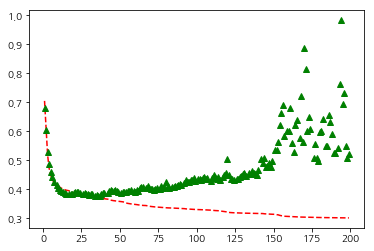

In [23]:
# 학습시킬 때마다 다른 결과가 나오기 때문에 Loss가 적어질때까지 여러 번 학습 시켜본다.
plt.plot(x_collect, train_loss_collect, "r--")
plt.plot(x_collect, valid_loss_collect, "g^")
plt.show()

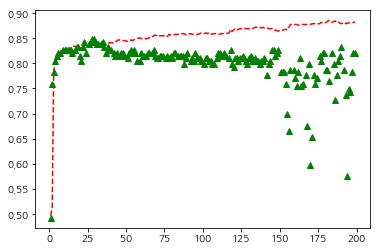

In [24]:
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g^")
plt.show()

In [25]:
model = build_neural_network()
restorer = tf.train.Saver()
with tf.Session() as sess:
    restorer.restore(sess,"./titanic.ckpt")
    feed = {
        model.inputs: test_data,
        model.is_training: False
    }
    test_predict = sess.run(model.predicted, feed_dict = feed)
    
test_predict[:10]

INFO:tensorflow:Restoring parameters from ./titanic.ckpt


array([[3.6554776e-02],
       [9.3290800e-01],
       [4.5967888e-04],
       [8.5955322e-02],
       [1.5072168e-01],
       [4.6294868e-01],
       [9.5219076e-01],
       [1.6745520e-01],
       [7.8182715e-01],
       [3.4138316e-03]], dtype=float32)

In [26]:
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(0.5)
test_predict_result = binarizer.fit_transform(test_predict)
test_predict_result = test_predict_result.astype(np.int32)
test_predict_result[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

In [27]:
passenger_id = test_passenger_id.copy()
evaluation = passenger_id.to_frame()
evaluation["Survived"] = test_predict_result
evaluation[:10]

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [28]:
evaluation.to_csv("submission/tf_submission.csv",index=False)

In [29]:
# 캐글 커널 코드에 학습횟수(epoch)와 배치 사이즈를 늘려서 돌려주고 제출했을 때 
# 캐글 스코어 0.78947 로 상위 30% 이내의 점수를 얻을 수 있다.
print('{:.2f}'.format(2154/7481))
# 원래 코드에 Embarked 인코딩을 추가하면 상위 15%의 점수를 얻을 수 있다.
# 캐글 스코어 0.80382 
print('{:.2f}'.format(1118/7481))

0.29
0.15
